In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/CUDA/11.7.0"

import tensorflow as tf
from tensorflow.keras import backend as K

from UNET import UNET3D

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
plt.rcParams.update({'font.size': 13})
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
BoxSize = 1000.
kF = 2*np.pi/BoxSize
grid = 256

In [3]:
X_data = np.array([np.load(f"/scratch/p301831/Quijote_Density_256/fiducial/0/df_m_256_PCS_fiducial_z=0_{i}.npy") for i in tqdm(range(60))])
y_data = np.array([np.load(f"/scratch/p301831/Quijote_Density_256/fiducial/127/df_m_256_PCS_fiducial_z=127_{i}.npy") for i in tqdm(range(60))])

100%|██████████| 60/60 [00:02<00:00, 25.13it/s]


In [4]:
def cutfield(delta,BoxSize,grid,maxk_kF):
    # Cuts the density field at kmax = maxk_kF * kF 
    kF = 2*np.pi/BoxSize
    cell_size = BoxSize/grid
    # indexing="ij" means the array are indexed A[xi][yi][zi]
    kx = 2 * np.pi * np.fft.fftfreq(grid, cell_size)
    ky = 2 * np.pi * np.fft.fftfreq(grid, cell_size)
    kz = 2 * np.pi * np.fft.rfftfreq(grid, cell_size)
    k = tf.meshgrid(kx,ky,kz,indexing="ij")
    kgrid = tf.sqrt(k[0]**2 + k[1]**2 + k[2]**2)

    bools = (kgrid >= maxk_kF*kF)
    
    c_fftgrid = tf.signal.rfft3d(delta)
    c_fftgrid = tf.where(bools,0.+0.j,c_fftgrid)
    r_fftgrid = tf.signal.irfft3d(c_fftgrid)

    return r_fftgrid

In [5]:
# Cut and normalize the output fields
y_data = cutfield(y_data,BoxSize,grid,82.5).numpy()
y_data /= y_data.reshape(len(y_data),-1).std()

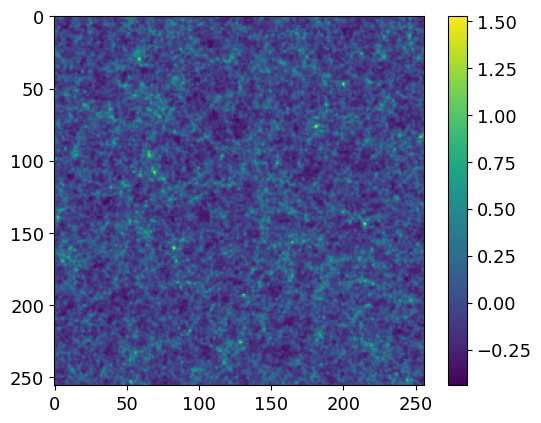

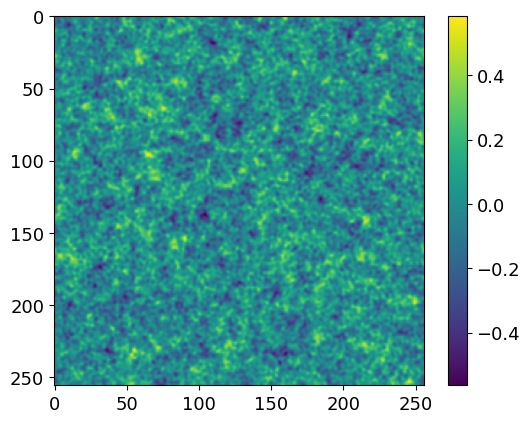

In [6]:
plt.imshow(X_data[0,:,:,:].mean(2))
plt.colorbar()
plt.show()

plt.imshow(y_data[0,:,:,:].mean(2))
plt.colorbar()
plt.show()

In [7]:
# Split in training and validation data
X_train = X_data[:48][:,:,:,:,np.newaxis]
X_val = X_data[48:][:,:,:,:,np.newaxis]

y_train = y_data[:48][:,:,:,:,np.newaxis]
y_val = y_data[48:][:,:,:,:,np.newaxis]

print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(48, 256, 256, 256, 1) (12, 256, 256, 256, 1) (48, 256, 256, 256, 1) (12, 256, 256, 256, 1)


In [8]:
train_data = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(1)
val_data = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(1)


In [9]:
K.clear_session()

model = UNET3D(256, n_base_filters=8,depth=5,loss_function=tf.keras.losses.mse,initial_learning_rate=1e-3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 density (InputLayer)           [(None, 256, 256, 2  0           []                               
                                56, 1)]                                                           
                                                                                                  
 displacement_tensors (displace  (None, 256, 256, 25  0          ['density[0][0]']                
 ment_tensors)                  6, 6)                                                             
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 25  0           ['density[0][0]',                
                                6, 7)                             'displacement_tensors[0][0]'

In [10]:
def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * 0.95
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = "256_nbasefilter8_depth5_z0_checkpoint"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [13]:
model.fit(x=train_data, validation_data=val_data, shuffle=True,batch_size=1, epochs=1000,validation_freq=1,callbacks=[model_checkpoint_callback])

Epoch 1/1000
 3/48 [>.............................] - ETA: 1:36 - loss: 0.7596


KeyboardInterrupt



In [13]:
model.load_weights("256_nbasefilter8_depth5_z0_checkpoint")

In [11]:
ii = 0
preds = model.predict(X_val[ii][np.newaxis,:,:,:])[0,:,:,:]

1/1 [==============================] - 2s 2s/step


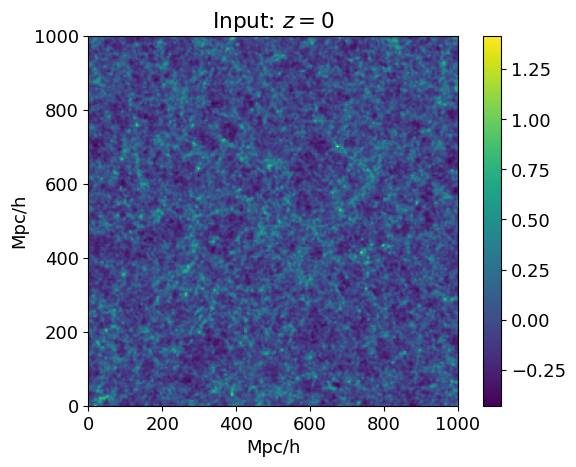

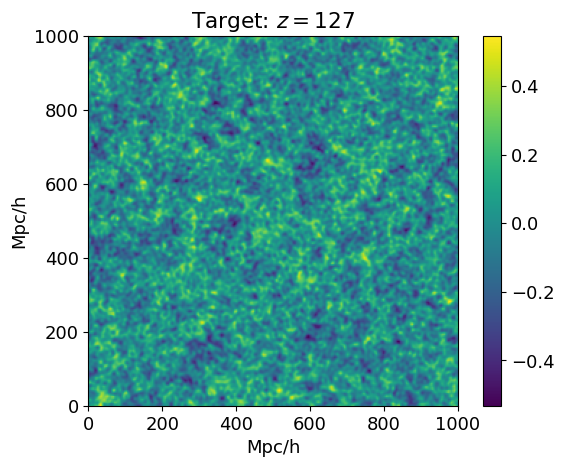

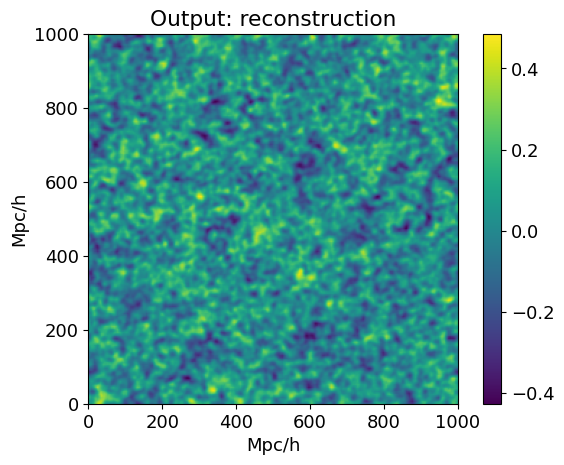

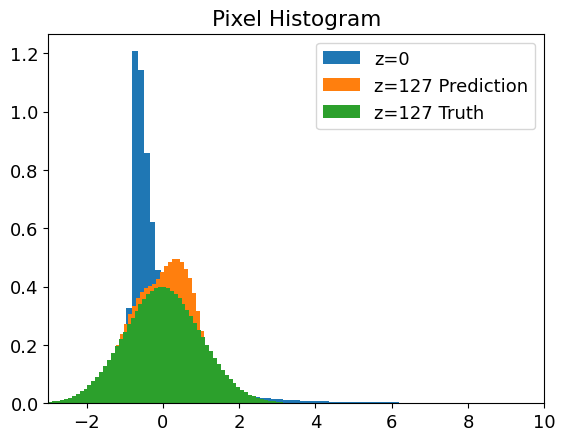

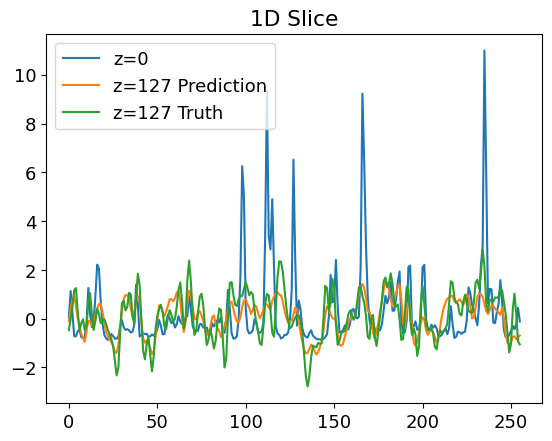


Computing power spectra of the fields...
Time FFTS = 0.30
Time loop = 0.91
Time taken = 1.21 seconds

Computing power spectra of the fields...
Time FFTS = 0.19
Time loop = 1.05
Time taken = 1.24 seconds


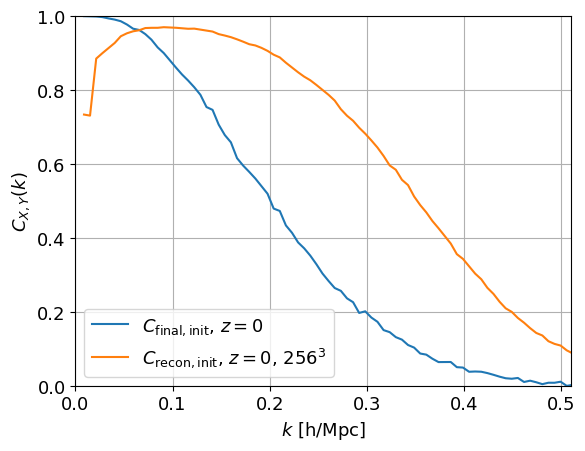

In [12]:
import Pk_library as PKL

plt.imshow(X_val[ii,:,:,:,0].mean(2),extent=[0,1000,0,1000])
plt.xlabel('Mpc/h')
plt.ylabel('Mpc/h')
plt.colorbar()
plt.title("Input: $z=0$")
# plt.savefig("results/2D_z0_real.pdf",format='pdf',bbox_inches='tight')
plt.show()

plt.imshow(y_val[ii,:,:,:,0].mean(2),extent=[0,1000,0,1000])
plt.xlabel('Mpc/h')
plt.ylabel('Mpc/h')
plt.colorbar()
plt.title("Target: $z=127$")
# plt.savefig("results/2D_z127_real.pdf",format='pdf',bbox_inches='tight')
plt.show()

plt.imshow(preds[:,:].mean(2),extent=[0,1000,0,1000])
plt.xlabel('Mpc/h')
plt.ylabel('Mpc/h')
plt.colorbar()
plt.title("Output: reconstruction")
# plt.savefig("results/2D_recon_real.pdf",format='pdf',bbox_inches='tight')
plt.show()

plt.hist(X_val[ii].ravel(),bins=1000,density=True)
plt.hist(preds.ravel(),bins=100,density=True)
plt.hist(y_val[ii].ravel(),bins=100,density=True)
plt.title("Pixel Histogram")
plt.xlim(-3,10)
plt.legend(["z=0","z=127 Prediction","z=127 Truth"])
plt.show()

plt.plot(X_val[ii,20,20,:,0])
plt.plot(preds[20,20])
plt.plot(y_val[ii,20,20,:,0])
plt.title("1D Slice")
plt.legend(["z=0","z=127 Prediction","z=127 Truth"])
plt.show()

Pkcross = PKL.XPk([X_val[ii,:,:,:,0],y_val[ii,:,:,:,0]], 1000., axis=0, MAS=['PCS',"PCS"], threads=8)
cross_pre = Pkcross.XPk[:,0,0]/np.sqrt(Pkcross.Pk[:,0,0]*Pkcross.Pk[:,0,1])
Pkcross = PKL.XPk([preds[:,:,:,0],y_val[ii,:,:,:,0]], 1000., axis=0, MAS=[None,"PCS"], threads=8)
cross_recon = Pkcross.XPk[:,0,0]/np.sqrt(Pkcross.Pk[:,0,0]*Pkcross.Pk[:,0,1])
plt.plot(Pkcross.k3D,cross_pre,label="$C_{\\rm final,init}$, $z=0$")
plt.plot(Pkcross.k3D,cross_recon,label="$C_{\\rm recon,init}$, $z=0$, $256^3$")

plt.xlim(0,81.25*kF)
plt.legend()
plt.xlabel("$k$ [h/Mpc]")
plt.ylabel("$C_{X,Y}(k)$")
plt.ylim(0,1)
plt.grid()
plt.show()